# Generate experiment graphs

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Read data from events file

In [2]:
def pandas_from_tf_events(path):
    events = [e for e in tf.train.summary_iterator(str(path))]
    
    t0 = events[0].wall_time
    
    def event_to_dict(event):
        summary = event.summary.value
        
        if len(summary) != 1:
            raise ValueError(f'Found event with summary of length {len(summary)}. Expected length is 1.')
        
        return {'time_minutes': (event.wall_time - t0) / 60.0, 'step': event.step, summary[0].tag: summary[0].simple_value}
        
    
    values_long = pd.DataFrame([
        event_to_dict(e) 
        for e in events 
        if len(e.summary.value) >= 1])
    
    return values_long.groupby('step').mean().sort_index().reset_index()

In [16]:
def plot_several_experiment_curves(
        experiments, title, x_value='steps', save_name=None, xlim=None, colors=None):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    ylim = (0, 3)
    plt.ylim(ylim)
    if x_value == 'steps':
        plt.xlabel('Number of steps')
        x_index = 'step'
    else:
        plt.xlabel('Time elapsed in minutes')
        x_index = 'time_minutes'
    plt.ylabel('Average reward (100 episodes)')
    
    if colors is None:
        colors = ['red', 'orange', 'green', 'blue', 'purple']
    
    for [title, path], color in zip(experiments, colors):
        event_df = pandas_from_tf_events(path)
        plt.plot(
            event_df[x_index], 
            event_df['rollout/ep_rew_mean'],
            label=title,
            color=color)
        episode_solutions = event_df[event_df['rollout/ep_rew_mean'] >= 0.5]
        first_solution = None if len(episode_solutions) == 0 else episode_solutions.iloc[0][x_index]
        
        if first_solution:
            plt.vlines(
                first_solution, 
                *ylim, 
                color=color, 
                linestyle='--', 
                linewidth=1,
                label=(
                    f'solved at step {int(first_solution)}' 
                    if x_value == 'steps' 
                    else f'solved in {first_solution:.2f} minutes'))
    
    plt.legend()
    if save_name:
        plt.savefig(Path('../artifacts') / (save_name + '.png'))
    plt.show()

## SAC

In [17]:
experiments_arch = [
    ('SAC', '../experiments/sac_zoo/tensorboard_logs/SAC_3/events.out.tfevents.1592203502.mariosk-G3-3590.12021.0'),
]

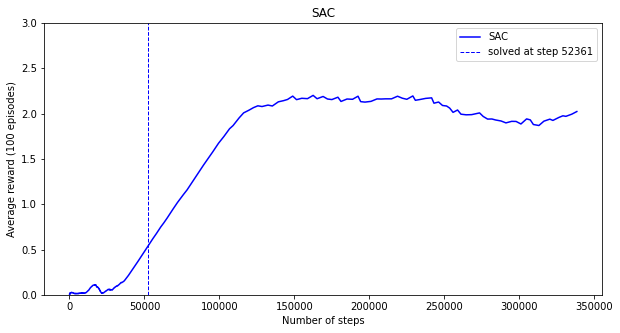

In [18]:
plot_several_experiment_curves(
    experiments_arch, 
    'SAC',
    save_name='rewards_curve',
    colors=['blue'])